In [ ]:
# #  instead of importing loopify, let's %run it:
# %run /data/venevs/loops_stuff/cooloop/loopify.py
# %run /data/venevs/loops_stuff/cooloop/old_loopify.py
# %run /data/venevs/loops_stuff/cooloop/plotools.py

In [13]:
#helper functions ...
import cooler
import cooltools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from scipy.stats import poisson
# from cooltools.plotools import show_heatmap_wfeat, get_kernel

from cooltools.loopify import diagonal_matrix_tiling, \
                              tile_of_expected, \
                              get_adjusted_expected_tile_some_nans, \
                              multiple_test_BH, \
                              clust_2D_pixels, \
                              square_matrix_tiling
                
                
from cooltools.old_loopify import get_adjusted_expected, \
                                  get_adjusted_expected_some_nans, \
                                  get_adjusted_expected_tile
                
from cooltools.snipping import LazyToeplitz
            
from cooltools.plotools import get_kernel
            
from copy import deepcopy
from bioframe import parse_humanized, parse_region_string
# from scipy.ndimage import convolve


### Inputs for `call_loops_per_chrom`

Prepare a nice cooler-file, chromosome of interest, expected in `pd.DataFrame` format, and for now, just a single `kernels=[kernel, ]` to perform peak-calling against locally-adjusted expected.  

In [6]:
# cname = './houda/Houda_Ctrl_DpnII_K562.20000.cool'
# cname = './houda/Houda_Ctrl_DpnII_K562.10000.cool'
cname = './anne-laure/PTB2539-NT.20000.cool'
ename = cname.rstrip(".cool") + ".cis.expected"
the_c = cooler.Cooler(cname)
for k,v in the_c.info.items():
    print(k,v)
# resolution aka bin-size,
# typically 5000,10000,20000 (5-20 KB)
b = the_c.info['bin-size']

#chromosome of interest
chrom = "chr17"

# # Run CLI expected when needed:
# !cooltools compute_expected --contact-type cis --nproc 18 $cname > $ename
cis_exp = pd.read_table(ename,index_col=[0,1])
# # trans expected, just for the record:
# !cooltools compute_expected --contact-type trans PTB2539-NT.200000.cool > PTB2539-NT.200000.trans.expected
# trans_exp = pd.read_table("PTB2539-NT.200000.trans.expected",index_col=[0,1])

bin-type fixed
bin-size 20000
nchroms 25
nbins 154795
sum 1106009388
nnz 510537257
genome-assembly hg19
metadata {}
creation-date 2017-12-11T06:24:11.564370
generated-by cooler-0.7.5
format HDF5::Cooler
format-version 2
format-url https://github.com/mirnylab/cooler


### Donut mask

let's create a donut shape mask for downstream analysis ...

We're exploring 10KB Hi-C matrix in this example, but donut-mask parameters, probably must be different for 10kb, look up Rao et el. 2014.

params are not the most efficient, perhaps ...

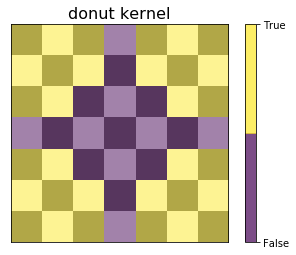

In [7]:
w = 3
p = 1
kernel = get_kernel(w,p,ktype='donut')

# kernel/kernel.sum()

### Trying the loopify:

Let's finally try to call peaks using loopify:

In [8]:

from scipy.linalg import toeplitz

# assuming cooler, chrom and expected as input ...
ice_v_name = "weight"
exp_v_name = "balanced.avg"

M_raw = the_c.matrix(balance=False).fetch(chrom)
M_ice = the_c.matrix().fetch(chrom)
M_raw = the_c.matrix(balance=False).fetch(chrom)
v_ice = the_c.bins().fetch(chrom)[ice_v_name].as_matrix()

exp_v = cis_exp.loc[chrom][exp_v_name].values
# We'll reconstruct a 2D expected matrix from 
# the `exp_v` for ease of coding for now, 
# but overall it is another major inefficiency
# of the code (memory-footprint etc).
E_ice = toeplitz(exp_v)
# GLOBAL expected:
# deiced E_ice: element-wise division of E_ice[i,j] and
# v_ice[i]*v_ice[j]:
E_raw = np.divide(E_ice, np.outer(v_ice,v_ice))

# chunking attempt 

try doing the same as above (extracting dense matrices), only for small chunks along the diagonal this time around
```

    * * * * * * * * * * *  0-th slice
    *       *           *
    *       *           *
    *   * * * * *       *  i-th slice
    *   *   *   *       *
    * * * * *   *       *
    *   *       *       *
    *   * * * * *       *
    *                   *
    *              ...  *  ...
    *                   *
    *                   *
    * * * * * * * * * * *
    
```


In [9]:
###################################
# little side-step to generate the test-case
# that we use in the cooloop test-suite ... 
###################################
L,L = M_ice.shape
M = int(parse_humanized('2M')/b)
# w-edge ...

T = L//M + bool(L%M)

tiles_origin = []
tiles_M_ice = []
tiles_M_raw = []
tiles_E_ice = []
tiles_v_ice = []
# by doing range(1,T) we are making
# sure we are processing the upper-left
# chunk only once:
for t in range(1,T):
    # l = max(0,M*t-M)
    # r = min(L,M*t+M)
    lw = max(0,M*t-M-w)
    rw = min(L,M*t+M+w)
    #
    origin_lw = (lw,lw)
    tiles_origin.append(origin_lw)
    tiles_M_ice.append(M_ice[lw:rw,lw:rw])
    tiles_M_raw.append(M_raw[lw:rw,lw:rw])
    tiles_E_ice.append(E_ice[lw:rw,lw:rw])
    tiles_v_ice.append(v_ice[lw:rw])

# # there you go!
# # here are your tiles ...
# print(np.isfinite(tiles_M_ice[15]).sum())

mock_M_raw = tiles_M_raw[28]
mock_M_ice = tiles_M_ice[28]
mock_E_ice = tiles_E_ice[28]
mock_v_ice = tiles_v_ice[28]
# mock_M_ice = tiles_M_ice[15]

##############################
# new stuff for the cooloop test only:
##############################

# # kernels=(kernel,)
# b=the_c.info['bin-size']

# ####################################################
# # # first, generate that locally-adjusted expected:
# # # MOCK-results saving:
# ####################################################
# # # Ed_raw, mask_ndx, Cobs, Cexp, NN = 
# # res = get_adjusted_expected(observed=mock_M_ice,
# #                      expected=mock_E_ice,
# #                      ice_weight=mock_v_ice,
# #                      kernel=kernel,
# #                      b=b,
# #                      return_type="sparse")
# # 
# # res[['row','col','expected','la_expected','observed']].to_csv("mock_res.csv.gz",compression="gzip",index=False)

# np.savez_compressed('mock_inputs',
#                     mock_M_raw=mock_M_raw,
#                     mock_M_ice=mock_M_ice,
#                     mock_E_ice=mock_E_ice,
#                     mock_v_ice=mock_v_ice)

# x_load = np.load('mock_inputs.npz')
# print(np.isclose(x_load['mock_M_raw'] ,mock_M_raw,equal_nan=True).all())
# print(np.isclose(x_load['mock_M_ice'] ,mock_M_ice,equal_nan=True).all())
# print(np.isclose(x_load['mock_E_ice'] ,mock_E_ice,equal_nan=True).all())
# print(np.isclose(x_load['mock_v_ice'] ,mock_v_ice,equal_nan=True).all())



# to be continued from here on ...

it is all updated up until this point,
but below it is still old, carrying a lot of 
things from retired loopify etc.

get inspiration from cooloop tests to update 
the sections below ...


## todo:

 - separate legacy code
 - cleanup the notebook
 - combine into 1 pipeline ...




In [10]:
#############################
# testing 3 legacy la_exp functions ...
#############################

nans_to_tolerate = 1
band_2Mb = 2e+6
kernels=(kernel,)
b=the_c.info['bin-size']

print("    Run 'get_adjusted_expected_tile' for a bunch of tiles ...")

peak_tiles = []
for origin,observed,expected,ice_weight in zip(tiles_origin,
                                               tiles_M_ice,
                                               tiles_E_ice,
                                               tiles_v_ice):
    peak_tile = get_adjusted_expected_tile(origin=origin,
                                               observed=observed,
                                               expected=expected,
                                               ice_weight=ice_weight,
                                               kernels=kernels,
                                               b=b,
                                               band=band_2Mb)
    peak_tiles.append(peak_tile)

peaks_tiles_concat = pd.concat(peak_tiles,ignore_index=True)



print("    Run 'get_adjusted_expected_some_nans' entire chromosome ...")

# first, generate that locally-adjusted expected:
# Ed_raw, mask_ndx, Cobs, Cexp, NN
peaks_nans = get_adjusted_expected_some_nans(
                                        observed = M_ice,
                                        expected = E_ice,
                                        ice_weight = v_ice,
                                        kernels = kernels,
                                        b = b,
                                        band = band_2Mb,
                                        nan_threshold=nans_to_tolerate
                                       )


print("    Run 'get_adjusted_expected' entire chromosome (the most original la_exp) ...")


peaks_original = get_adjusted_expected(
                             observed=M_ice,
                             expected=E_ice,
                             ice_weight=v_ice,
                             kernel=kernel,
                             b=b,
                             return_type="sparse")




    Run 'get_adjusted_expected_tile' for a bunch of tiles ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels convolved with observed and expected ...
kernels

/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/old_loopify.py:521: RuntimeWarning: invalid value encountered in true_divide
  Ed_raw = np.multiply(E_raw, np.divide(KM, KE))


    Run 'get_adjusted_expected' entire chromosome (the most original la_exp) ...
kernels convolved with observed and expected ...
mask_Ed include all elements of mask_M (expected)
mask_Ed include all elements of mask_NN (expected)
But mask_Ed!=mask_NN (expected e.g. for NN>=2)
If all test yield as expected, masking is practically useless ...


## testing new tiling strategies:

 - diag
 - square tiling 
 
 very awesome
 
 very cool

In [14]:
#################################################
# exp_getter = lambda start,stop,shift: cis_exp.iloc[start+shift:stop+shift][exp_v_name].values
#################################################
chr_start,chr_stop = the_c.extent(chrom)
b = the_c.info['bin-size']
band_2Mb = 2e+6
band_idx = int(band_2Mb/b)
w = 3
nans_tolerated = 1
tile_size = int(12e6/b)
verbosity = True
lazy_exp = LazyToeplitz(cis_exp.loc[chrom][exp_v_name].values)

###############
# now with 2 kernels after update
# it takes forever on an entire matrix ...
###############

#################################################
# test the newest 'get_adjusted_expected_tile_some_nans'
# for the entire chrom , just in case ...
#################################################
print("(1)   Running the newest 'get_la_exp_tiles_nans' on an entire chrom (single piece) ...")

# let's keep X,Y-part explicit here:
origin = (chr_start, chr_start)
# RAW observed matrix slice:
observed = the_c.matrix(balance=False)[chr_start:chr_stop,chr_start:chr_stop]
# trying new expected function:
expected = lazy_exp[chr_start:chr_stop,chr_start:chr_stop]
#################################################
# expected = tile_of_expected(chr_start,
#                             (chr_start, chr_stop),
#                             (chr_start, chr_stop),
#                             exp_getter)
#################################################
# that's the main working function from loopify:
res_df = get_adjusted_expected_tile_some_nans(origin = origin,
                                         observed = observed,
                                         expected = expected,
                                         bal_weight = the_c.bins()[chr_start:chr_stop][ice_v_name].values,
                                         kernels = {"donut":kernel, "footprint":np.ones_like(kernel)},
                                         verbose = verbosity)
is_inside_band = (res_df["row"]>(res_df["col"]-band_idx))
does_comply_nans = (res_df["la_exp."+"footprint"+".nnans"] < nans_tolerated)
# so, selecting inside band and nNaNs compliant results:
res_df = res_df[is_inside_band & does_comply_nans].reset_index(drop=True)
# adjust the origin
res_df['row'] = res_df['row'] - chr_start
res_df['col'] = res_df['col'] - chr_start
# save using a distinct name:
new_peaks_entire_chrom = res_df




#################################################
# test the newest 'get_adjusted_expected_tile_some_nans'
# using diagonal chunking here ...
#################################################
print("(2)   Running the newest 'get_la_exp_tiles_nans' with diagonal chunking ...")

res_df = pd.DataFrame([])
for tile in diagonal_matrix_tiling(chr_start, chr_stop, w, band = band_idx):
    tilei = tile
    tilej = tile
    # let's keep i,j-part explicit here:
    origin = (tilei[0], tilej[0])
    # RAW observed matrix slice:
    observed = the_c.matrix(balance=False)[slice(*tilei), slice(*tilej)]
    # expected as a tile :
    expected = lazy_exp[slice(*tilei), slice(*tilej)]
    #################################################
    # expected = tile_of_expected(chr_start, tilei, tilej, exp_getter)
    #################################################
    ice_weight = the_c.bins()[slice(*tile)][ice_v_name].values
    # that's the main working function from loopify:
    res = get_adjusted_expected_tile_some_nans(origin = origin,
                                             observed = observed,
                                             expected = expected,
                                             bal_weight = ice_weight,
                                             kernels = {"donut":kernel, "footprint":np.ones_like(kernel)},
                                             verbose = verbosity)
    is_inside_band = (res["row"]>(res["col"]-band_idx))
    does_comply_nans = (res["la_exp."+"footprint"+".nnans"] < nans_tolerated)
    # so, selecting inside band and nNaNs compliant results:
    res_df = res_df.append(
                res[is_inside_band & does_comply_nans],
                ignore_index=True)
# drop dups and reset index:
res_df = res_df.drop_duplicates().reset_index(drop=True)
# adjust the origin :
res_df['row'] = res_df['row'] - chr_start
res_df['col'] = res_df['col'] - chr_start
# save using a distinct name:
new_peaks_diag_tiles = res_df



#################################################
# test the newest 'get_adjusted_expected_tile_some_nans'
# using square chunking here (the most arbitrary) ...
#################################################
print("(3)   Running the newest 'get_la_exp_tiles_nans' with arbitrary square chunking ...")

res_df = pd.DataFrame([])
for tilei, tilej in square_matrix_tiling(chr_start, chr_stop, tile_size = tile_size, edge = w, square = False):
    # let's keep i,j-part explicit here:
    origin = (tilei[0], tilej[0])
    # RAW observed matrix slice:
    observed = the_c.matrix(balance=False)[slice(*tilei),slice(*tilej)]
    # trying new expected function:
    expected = lazy_exp[slice(*tilei), slice(*tilej)]
    ###################################################
    # expected = tile_of_expected(chr_start, tilei, tilej, exp_getter)
    ###################################################
    ice_weight_i = the_c.bins()[slice(*tilei)][ice_v_name].values
    ice_weight_j = the_c.bins()[slice(*tilej)][ice_v_name].values
    # that's the main working function from loopify:
    res = get_adjusted_expected_tile_some_nans(origin = origin,
                                             observed = observed,
                                             expected = expected,
                                             bal_weight = (ice_weight_i, ice_weight_j),
                                             kernels = {"donut":kernel, "footprint":np.ones_like(kernel)},
                                             verbose=verbosity)
    is_inside_band = (res["row"]>(res["col"]-band_idx))
    does_comply_nans = (res["la_exp."+"footprint"+".nnans"] < nans_tolerated)
    # so, selecting inside band and nNaNs compliant results + appending:
    res_df = res_df.append(
                res[is_inside_band & does_comply_nans],
                ignore_index=True)
# drop dups and reset index:
res_df = res_df.drop_duplicates().reset_index(drop=True)
# adjust the origin:
res_df['row'] = res_df['row'] - chr_start
res_df['col'] = res_df['col'] - chr_start
# save using a distinct name:
new_peaks_square_tiles = res_df



(1)   Running the newest 'get_la_exp_tiles_nans' on an entire chrom (single piece) ...


/home/venevs/miniconda3/lib/python3.6/site-packages/cooltools/loopify.py:659: RuntimeWarning: invalid value encountered in true_divide
  Ek_raw = np.multiply(E_raw, np.divide(KO, KE))


Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
(2)   Running the newest 'get_la_exp_tiles_nans' with diagonal chunking ...
matrix of size 4060X4060 to be splitted so that
  diagonal region of size 100 would be completely
  covered by the tiling, additionally keeping
  a small 'edge' of size w=3, to allow for
  meaningfull convolution around boundaries.
  Resulting number of tiles is 40
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donu

Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.
Convolution with kernel donut is complete.
Convolution with kernel footprint is complete.


# validation between different get_la_exp methods ...

validate by concatenating supposedly identical results and then deduplicating that stuff ...

good outcome should be EMPTY 

I.E. ALL ENTRIES HAVE THEIR IDENTICAL "TWINS" ...


we've got a bunch of DataFrames to compare (legacy stuff):
 - `peaks_tiles_concat` with locally adjusted expected calculated using legacy `get_adjusted_expected_tile` (diag-chunks)
 - `peaks_nans` calculated using legacy `get_adjusted_expected_some_nans` (entire chrom as a single piece)
 - `peaks_original` caluclated using legacy `get_adjusted_expected` (entire chrom as a single piece, the most ORIGINAL one)
 
new DataFrames :
 - `new_peaks_entire_chrom` calculated using the newest `get_adjusted_expected_tile_some_nans` for entire chrom in 1 piece.
 - `new_peaks_diag_tiles` calculated using the newest `get_adjusted_expected_tile_some_nans` using diagonal chunking/tiling.
 - `new_peaks_square_tiles` calculated using the newest `get_adjusted_expected_tile_some_nans` using square chunking/tiling.


In [15]:

a = peaks_tiles_concat[['row','col']]
b = peaks_nans[['row','col']]
c = peaks_original[['row','col']]

d = new_peaks_entire_chrom[['row','col']]
e = new_peaks_diag_tiles[['row','col']]
f = new_peaks_square_tiles[['row','col']]

print(pd.concat([a,b,c,d,e,f]).drop_duplicates(keep=False))

# ##################
# # compatibility restored
# # no difference detected
# ##################
# print(pd.concat([aaa,bbb,ccc,ddd,eee,fff]).drop_duplicates(keep=False))
# # print(pd.concat([xxx,www]).drop_duplicates(keep=False))


# #####################
# # RESULTS IS SIPPOSED TO BE EMPTY
# # IF EVERYHTING IS OK !!!

Empty DataFrame
Columns: [row, col]
Index: []
